In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import math
import copy

#import skimage.io as io
from scipy.misc import bytescale

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Permute
from keras.layers import Convolution2D, Deconvolution2D, Cropping2D
from keras.layers import merge

Using TensorFlow backend.


In [3]:
from utils import fcn32_blank, fcn_32s_to_8s, prediction

In [5]:
import keras
keras.backend.set_image_dim_ordering('th')

In [6]:
image_size = 64*8
fcn32model = fcn32_blank(image_size)

In [7]:
print(fcn32model.layers[-1].output_shape)

(None, 21, 32, 32)


In [8]:
print fcn32model.layers[-2].get_weights()[0].shape

(21, 21, 4, 4)


In [9]:
fcn8model = fcn_32s_to_8s(fcn32model)

In [10]:
# INFO : dummy image array to test the model passes
imarr = np.ones((3,image_size,image_size))
imarr = np.expand_dims(imarr, axis=0)

#testmdl = Model(fcn32model.input, fcn32model.layers[10].output) # works fine
testmdl = fcn8model # works fine
testmdl.predict(imarr).shape

(1, 21, 512, 512)

In [ ]:
if (testmdl.predict(imarr).shape != (1,21,image_size,image_size)):
    print('WARNING: size mismatch will impact some test cases')

In [ ]:
fcn8model.summary() # visual inspection of model architecture

In [11]:
from scipy.io import loadmat

In [12]:
USETVG = True
if USETVG:
    data = loadmat('pascal-fcn8s-tvg-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
else:
    data = loadmat('pascal-fcn8s-dag.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    p = data['params']
    description = data['meta'][0,0].classes[0,0].description
    print(data.keys())

In [13]:
l.shape, p.shape, description.shape

((1, 46), (1, 40), (1, 21))

In [14]:
class2index = {}
for i, clname in enumerate(description[0,:]):
    class2index[str(clname[0])] = i
    
print(sorted(class2index.keys()))

['aeroplane', 'background', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [15]:
if False: # inspection of data structure
    print(dir(l[0,31].block[0,0]))
    print(dir(l[0,44].block[0,0]))

if False:
    print l[0,36].block[0,0].upsample, l[0,36].block[0,0].size
    print l[0,40].block[0,0].upsample, l[0,40].block[0,0].size
    print l[0,44].block[0,0].upsample, l[0,44].block[0,0].size, l[0,44].block[0,0].crop

In [16]:
for i in range(0, p.shape[1]-1-2*2, 2): # weights #36 to #37 are not all paired
    print(i,
          str(p[0,i].name[0]), p[0,i].value.shape,
          str(p[0,i+1].name[0]), p[0,i+1].value.shape)
print '------------------------------------------------------'
for i in range(p.shape[1]-1-2*2+1, p.shape[1]): # weights #36 to #37 are not all paired
    print(i,
          str(p[0,i].name[0]), p[0,i].value.shape)

(0, 'conv1_1f', (3, 3, 3, 64), 'conv1_1b', (64, 1))
(2, 'conv1_2f', (3, 3, 64, 64), 'conv1_2b', (64, 1))
(4, 'conv2_1f', (3, 3, 64, 128), 'conv2_1b', (128, 1))
(6, 'conv2_2f', (3, 3, 128, 128), 'conv2_2b', (128, 1))
(8, 'conv3_1f', (3, 3, 128, 256), 'conv3_1b', (256, 1))
(10, 'conv3_2f', (3, 3, 256, 256), 'conv3_2b', (256, 1))
(12, 'conv3_3f', (3, 3, 256, 256), 'conv3_3b', (256, 1))
(14, 'conv4_1f', (3, 3, 256, 512), 'conv4_1b', (512, 1))
(16, 'conv4_2f', (3, 3, 512, 512), 'conv4_2b', (512, 1))
(18, 'conv4_3f', (3, 3, 512, 512), 'conv4_3b', (512, 1))
(20, 'conv5_1f', (3, 3, 512, 512), 'conv5_1b', (512, 1))
(22, 'conv5_2f', (3, 3, 512, 512), 'conv5_2b', (512, 1))
(24, 'conv5_3f', (3, 3, 512, 512), 'conv5_3b', (512, 1))
(26, 'fc6f', (7, 7, 512, 4096), 'fc6b', (4096, 1))
(28, 'fc7f', (1, 1, 4096, 4096), 'fc7b', (4096, 1))
(30, 'score_frf', (1, 1, 4096, 21), 'score_frb', (21, 1))
(32, 'score2f', (4, 4, 21, 21), 'score2b', (21, 1))
(34, 'score_pool4f', (1, 1, 512, 21), 'score_pool4b', (21, 

In [17]:
for i in range(l.shape[1]):
    print(i,
          str(l[0,i].name[0]), str(l[0,i].type[0]),
          [str(n[0]) for n in l[0,i].inputs[0,:]],
          [str(n[0]) for n in l[0,i].outputs[0,:]])

(0, 'conv1_1', 'dagnn.Conv', ['data'], ['conv1_1'])
(1, 'relu1_1', 'dagnn.ReLU', ['conv1_1'], ['conv1_1x'])
(2, 'conv1_2', 'dagnn.Conv', ['conv1_1x'], ['conv1_2'])
(3, 'relu1_2', 'dagnn.ReLU', ['conv1_2'], ['conv1_2x'])
(4, 'pool1', 'dagnn.Pooling', ['conv1_2x'], ['pool1'])
(5, 'conv2_1', 'dagnn.Conv', ['pool1'], ['conv2_1'])
(6, 'relu2_1', 'dagnn.ReLU', ['conv2_1'], ['conv2_1x'])
(7, 'conv2_2', 'dagnn.Conv', ['conv2_1x'], ['conv2_2'])
(8, 'relu2_2', 'dagnn.ReLU', ['conv2_2'], ['conv2_2x'])
(9, 'pool2', 'dagnn.Pooling', ['conv2_2x'], ['pool2'])
(10, 'conv3_1', 'dagnn.Conv', ['pool2'], ['conv3_1'])
(11, 'relu3_1', 'dagnn.ReLU', ['conv3_1'], ['conv3_1x'])
(12, 'conv3_2', 'dagnn.Conv', ['conv3_1x'], ['conv3_2'])
(13, 'relu3_2', 'dagnn.ReLU', ['conv3_2'], ['conv3_2x'])
(14, 'conv3_3', 'dagnn.Conv', ['conv3_2x'], ['conv3_3'])
(15, 'relu3_3', 'dagnn.ReLU', ['conv3_3'], ['conv3_3x'])
(16, 'pool3', 'dagnn.Pooling', ['conv3_3x'], ['pool3'])
(17, 'conv4_1', 'dagnn.Conv', ['pool3'], ['conv4_1'])


In [18]:
def copy_mat_to_keras(kmodel, verbose=True):
    
    kerasnames = [lr.name for lr in kmodel.layers]

    prmt = (3,2,0,1) # WARNING : important setting as 2 of the 4 axis have same size dimension
    
    for i in range(0, p.shape[1]):
        
        if USETVG:
            matname = p[0,i].name[0][0:-1]
            matname_type = p[0,i].name[0][-1] # "f" for filter weights or "b" for bias
        else:
            matname = p[0,i].name[0].replace('_filter','').replace('_bias','')
            matname_type = p[0,i].name[0].split('_')[-1] # "filter" or "bias"
        
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            if verbose:
                print 'found : ', (str(matname), str(matname_type), kindex)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            if  matname_type in ['f','filter']:
                l_weights = p[0,i].value
                f_l_weights = l_weights.transpose(prmt)
                f_l_weights = np.flip(f_l_weights, 2)
                f_l_weights = np.flip(f_l_weights, 3)
                assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
                current_b = kmodel.layers[kindex].get_weights()[1]
                kmodel.layers[kindex].set_weights([f_l_weights, current_b])
            elif matname_type in ['b','bias']:
                l_bias = p[0,i].value
                assert (l_bias.shape[1] == 1)
                assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
                current_f = kmodel.layers[kindex].get_weights()[0]
                kmodel.layers[kindex].set_weights([current_f, l_bias[:,0]])
        else:
            print 'not found : ', str(matname)

In [19]:
copy_mat_to_keras(fcn8model, False)

In [24]:
# im = Image.open('rgb.jpg') # http://www.robots.ox.ac.uk/~szheng/crfasrnndemo/static/rgb.jpg
# im = im.crop((0,0,319,319)) # WARNING : manual square cropping
# im = im.resize((image_size,image_size))

impath= "data/aa76df8711c84c5d14c4c606af10bea6.jpg"
im = Image.open(impath)
im = im.resize((image_size,image_size))

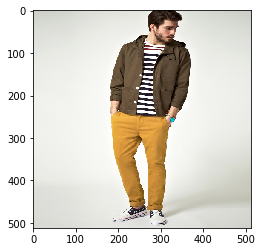

In [25]:
plt.imshow(np.asarray(im))

In [26]:
# WARNING : we do not deal with cropping here, this image is already fit
preds = prediction(fcn8model, im, transform=True)

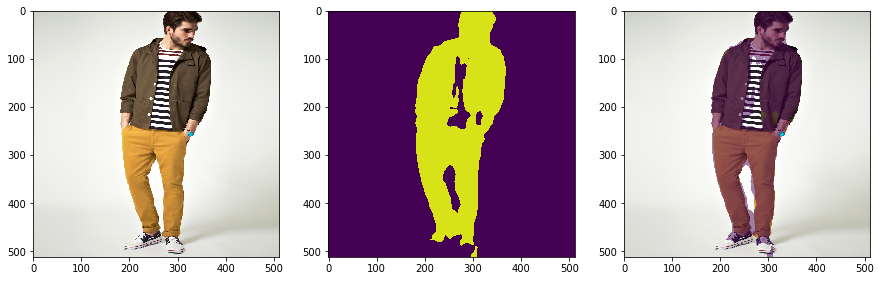

In [35]:
#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [33]:
# plt.imshow( masked_imclass, alpha=0.5 )
# plt.imshow( imclass )

In [ ]:
# Background removal from Mask

In [34]:
# Eroding countour

# import skimage.morphology
# import skimage.io as io

# # prediction_mask = (pred_np.squeeze() == 15)
# prediction_mask = imclass

# # Let's apply some morphological operations to
# # create the contour for our sticker

# image_np = np.asarray(im)

# cropped_object = image_np * np.dstack((prediction_mask,) * 3)

# square = skimage.morphology.square(5)

# temp = skimage.morphology.binary_erosion(prediction_mask, square)

# negative_mask = (temp != True)

# eroding_countour = negative_mask * prediction_mask

# eroding_countour_img = np.dstack((eroding_countour, ) * 3)

# cropped_object[eroding_countour_img] = 248

# png_transparancy_mask = np.uint8(prediction_mask * 255)

# image_shape = cropped_object.shape

# png_array = np.zeros(shape=[image_shape[0], image_shape[1], 4], dtype=np.uint8)

# png_array[:, :, :3] = cropped_object

# png_array[:, :, 3] = png_transparancy_mask

# io.imshow(cropped_object)

# Test/Demos

In [38]:
img_testarr1 = [ "https://s-media-cache-ak0.pinimg.com/564x/b9/b0/3b/b9b03bc3017acbbb3a34778033af947a.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/82/35/d1/8235d1e6d71b628dc9cacb9f9488a6f1.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/73/50/0f/73500f2cbe818d65b765dbbb297d3942.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/ec/4e/58/ec4e587d00000aede77cf3ad09ddbfdd.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/45/44/7d/45447da65f3caef7a45d368bbc2723e6.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/83/96/f7/8396f74410c8419a493f92ab3fde9f1d.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/e5/71/26/e571264246ae61bf035722a54918c139.jpg" ] 


img_testarr2=["https://s-media-cache-ak0.pinimg.com/564x/33/29/49/332949456398e697f17395b03b669702.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/26/e7/84/26e7843055edc1d2668d6fcb45728f28.jpg",
"https://s-media-cache-ak0.pinimg.com/564x/86/53/9a/86539af289761f971afc5715188c2111.jpg"]

In [57]:
img_men = ["https://s-media-cache-ak0.pinimg.com/564x/dc/39/d8/dc39d87fabce02302c3786c2f23204cf.jpg",
          "https://s-media-cache-ak0.pinimg.com/564x/eb/86/dc/eb86dcb732087309ef2ec622d0fe3d14.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/bf/cc/25/bfcc25224098fea7a50cf1e0833d64d0.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/95/55/9c/95559ca9a79f7da23522cb702e5eb2e8.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/26/d9/c6/26d9c68a8ffefcf9479c3acfd09f3a44.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/33/0f/5f/330f5f132b002775a7244167b9ffdfcf.jpg",
            "https://s-media-cache-ak0.pinimg.com/564x/ba/5b/f3/ba5bf3b30931a619302822d54939e2d1.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/06/1c/7e/061c7e2993fa7e653b87d4bf7fb3092b.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/fb/d9/c2/fbd9c27bc246e29e830c9661cab07f00.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/6c/d3/d7/6cd3d7dbd01629a60e4d73d3f0f520cf.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/90/ad/50/90ad5004d62b0af18a5a0b7406e18296.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/bb/5c/3b/bb5c3bfa993c7e30e0e310355a120372.jpg",
           "https://s-media-cache-ak0.pinimg.com/564x/9c/7d/3d/9c7d3de2f7eaa60465bac7e09e8a7267.jpg"
          ]

#0-12

# Women Fashion

In [39]:
from PIL import Image
import urllib2 as urllib
import io

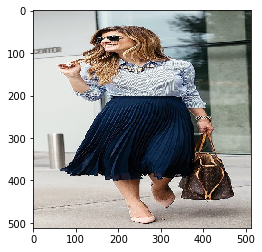

In [40]:
fd = urllib.urlopen(img_testarr1[0])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

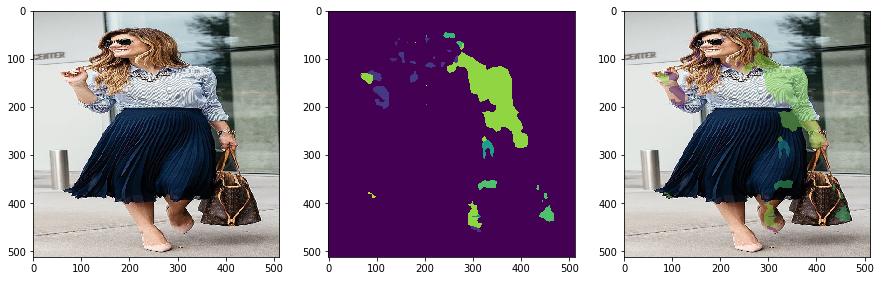

In [41]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

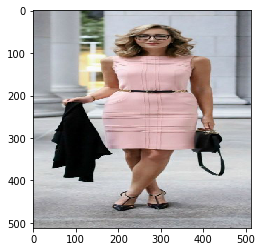

In [42]:
fd = urllib.urlopen(img_testarr1[1])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

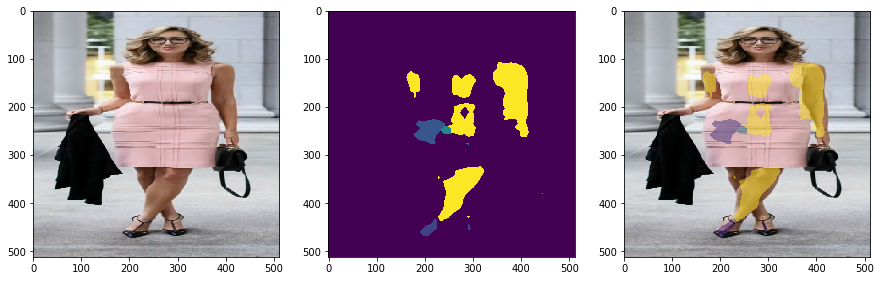

In [43]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

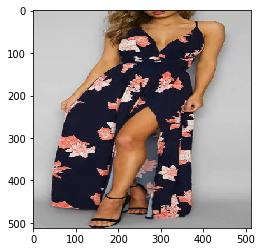

In [44]:
fd = urllib.urlopen(img_testarr1[2])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

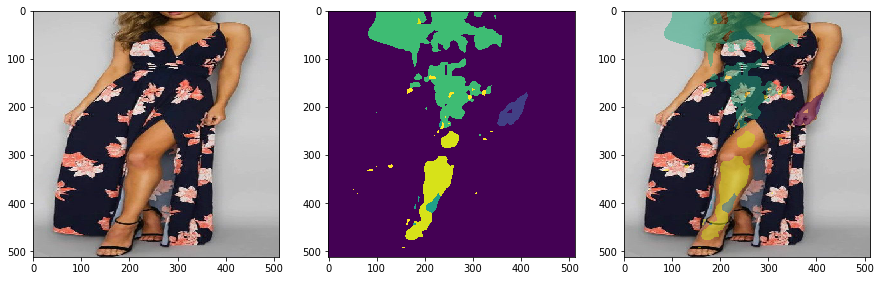

In [45]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

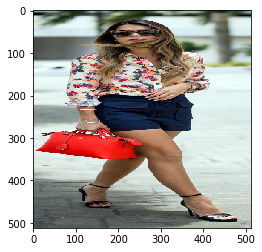

In [47]:
fd = urllib.urlopen(img_testarr1[3])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

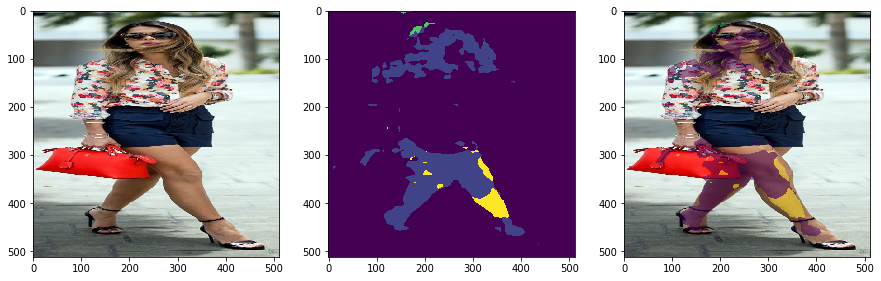

In [48]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

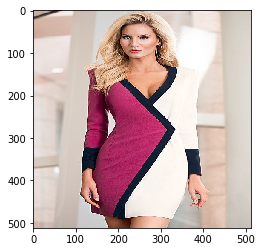

In [49]:
fd = urllib.urlopen(img_testarr1[4])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

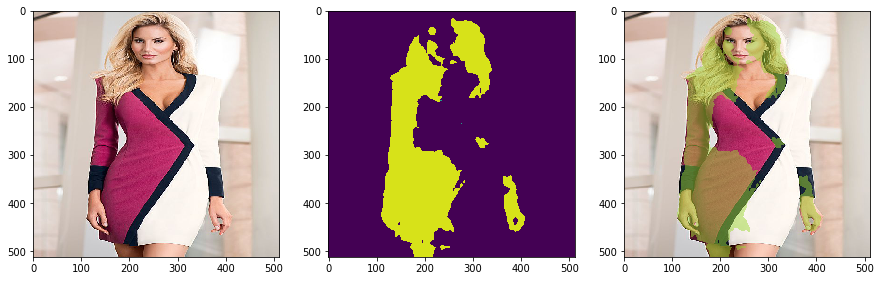

In [51]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

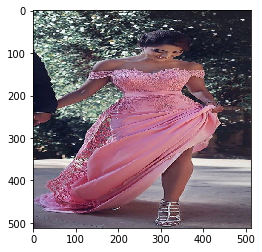

In [52]:
fd = urllib.urlopen(img_testarr1[5])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

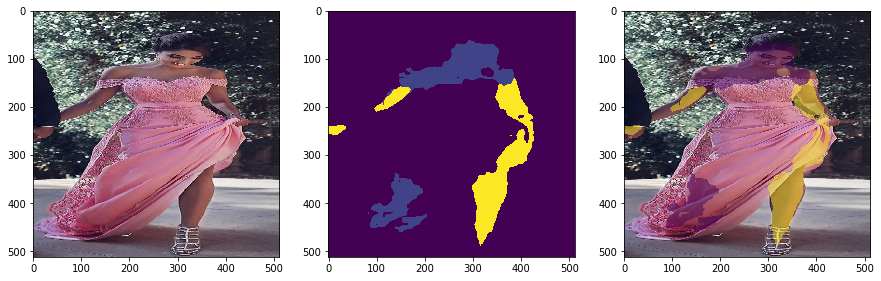

In [53]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

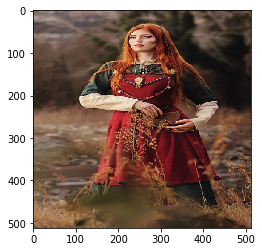

In [54]:
fd = urllib.urlopen(img_testarr1[6])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

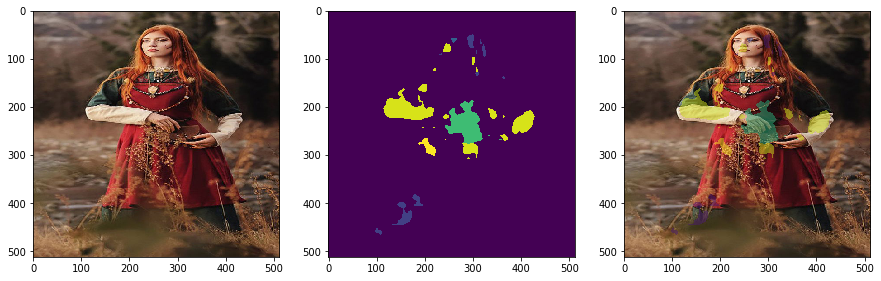

In [55]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

# Men Fashion

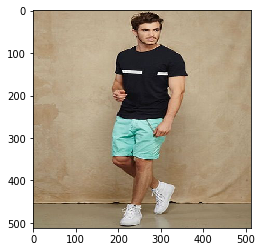

In [59]:
fd = urllib.urlopen(img_men[0])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

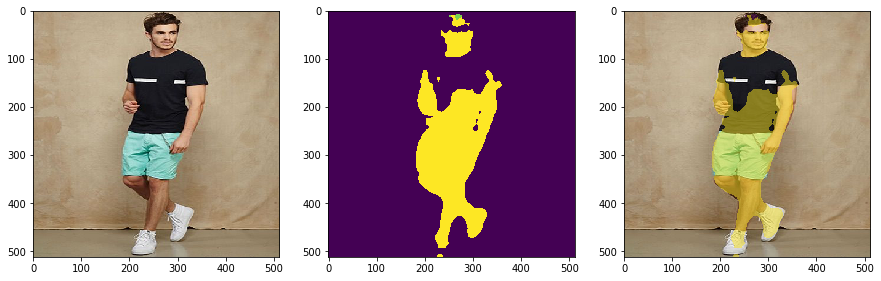

In [60]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

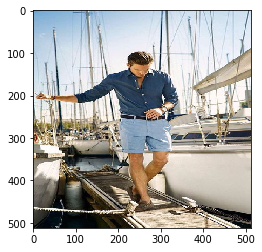

In [61]:
fd = urllib.urlopen(img_men[1])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

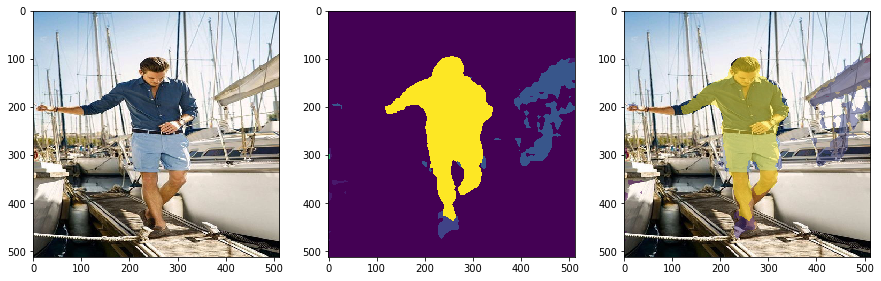

In [62]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [ ]:
fd = urllib.urlopen(img_men[2])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

In [ ]:
preds = prediction(fcn8model, im, transform=True)

# imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

In [ ]:
fd = urllib.urlopen(img_men[3])
image_file = io.BytesIO(fd.read())
im = Image.open(image_file)
# im = Image.open(impath)
im = im.resize((image_size, image_size))
plt.imshow(np.asarray(im))

In [ ]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )

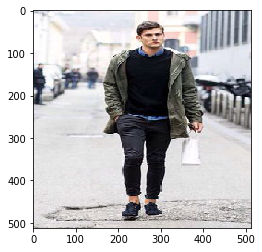

In [64]:
impath= "data/aa3e1445b8a14ab8b5b8107f1c5b8acb.jpg"
im = Image.open(impath)
im = im.resize((image_size,image_size))
plt.imshow(np.asarray(im))

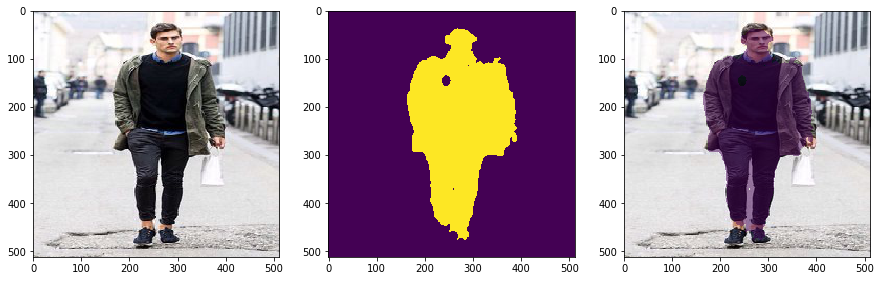

In [65]:
preds = prediction(fcn8model, im, transform=True)

#imperson = preds[0,class2index['person'],:,:]
imclass = np.argmax(preds, axis=1)[0,:,:]

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow( np.asarray(im) )
plt.subplot(1,3,2)
plt.imshow( imclass )
plt.subplot(1,3,3)
plt.imshow( np.asarray(im) )
masked_imclass = np.ma.masked_where(imclass == 0, imclass)
#plt.imshow( imclass, alpha=0.5 )
plt.imshow( masked_imclass, alpha=0.5 )